<a href="https://colab.research.google.com/github/fberetta8/ML_in_Finance_Spring_2025_ETH/blob/main/Solution1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The role of volatility in BS formula
This exercise should serve as a gentle introduction to the Black-Scholes formula, which plays a major role in quantitative finance. In this exercise we aim to write a NN which approximates the dependence of the price of an European call option on the volatility of the model.

In [ ]:
# Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import scipy.stats as si
import matplotlib.pyplot as plt

### Black-Scholes Formula

We consider the Black-Scholes formula for the price of a European call option:

$$
\begin{aligned}             
C(X,r,\sigma,T,K) &= X \Phi(d_1) - K e^{-rT} \Phi(d_2), \text{ where }\\
d_1 &=\frac{\ln(X/K) + (r + \frac{1}{2} \sigma^2)T}{\sigma \sqrt{T}}\\
d_2 &= d_1 - \sigma \sqrt{T}.
\end{aligned}
$$

In the above:
- $X$ is the price of the underlying asset,
- $r$ is the risk-free interest rate,
- $\sigma$ is the volatility of the market,
- $T$ is the time to maturity,
- $K$ is the strike price,
- $\Phi$ is the cumulative distribution function (CDF) of the standard normal distribution.

We shall discuss this model in detail in another lecture. For now, we fix the values:

$$
X=2, \quad r=0, \quad T=1, \quad K=1 \quad \sigma \in [0.01,1].
$$

Substituting these into the formula:

$$
\begin{aligned}             
C(\sigma) &= 2\Phi(d_1) - \Phi(d_2),\\
d_1 &= \frac{\ln(2) + \frac{1}{2} \sigma^2}{\sigma}\\
d_2 &= \frac{\ln(2) - \frac{1}{2} \sigma^2}{\sigma}.
\end{aligned}
$$


In [ ]:
# Black-Scholes formula
def black_scholes_formula(sigma, X=0.5, K=1, T=1, r=0):
    d1 = (np.log(X / K) + (0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return X * si.norm.cdf(d1) - K * si.norm.cdf(d2)

In [ ]:
# Generate Training Data
def generate_data(num_samples):
    # Generate `sigma` values uniformly between 0.01 and 1
    sigma_values = np.random.uniform(0.01, 1, num_samples).reshape(-1, 1)

    # Compute option prices using the Black-Scholes formula
    prices = black_scholes_formula(sigma_values)

    # Convert to PyTorch tensors
    X_train = torch.tensor(sigma_values, dtype=torch.float32)
    y_train = torch.tensor(prices, dtype=torch.float32).reshape(-1, 1)

    return X_train, y_train

In [ ]:
# Test your function
X_train, y_train = generate_data(10)
print("Sample Data:", X_train[:5], y_train[:5])

Sample Data: tensor([[0.8602],
        [0.7620],
        [0.4322],
        [0.2381],
        [0.4884]]) tensor([[6.8539e-02],
        [5.0844e-02],
        [6.9164e-03],
        [8.7186e-05],
        [1.1885e-02]])


In [ ]:
# Define Neural Network Model
class BlackScholesNN(nn.Module):
    def __init__(self, hidden_size=32, num_layers=3):
        super(BlackScholesNN, self).__init__()

        layers = [nn.Linear(1, hidden_size), nn.ReLU()]
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(hidden_size, 1))  # Output layer

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [ ]:
# Test your Model
model = BlackScholesNN(hidden_size=32, num_layers=3)
print(model)

BlackScholesNN(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [ ]:
# Train the model
def train_model(num_samples, num_layers=3, epochs=500, learning_rate=0.01):
    X_train, y_train = generate_data(num_samples)

    model = BlackScholesNN(num_layers=num_layers)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        optimizer.zero_grad()
        predictions = model(X_train)
        loss = criterion(predictions, y_train)
        loss.backward()
        optimizer.step()

        if epoch % 50 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

    return model, X_train, y_train

**Test 1**: Fix the network structure and vary the **number of training samples**



Epoch 0: Loss = 0.032274
Epoch 50: Loss = 0.000030
Epoch 100: Loss = 0.000001
Epoch 150: Loss = 0.000000
Epoch 200: Loss = 0.000000
Epoch 250: Loss = 0.000000
Epoch 300: Loss = 0.000000
Epoch 350: Loss = 0.000000
Epoch 400: Loss = 0.000000
Epoch 450: Loss = 0.000000
Epoch 0: Loss = 0.010807
Epoch 50: Loss = 0.000042
Epoch 100: Loss = 0.000002
Epoch 150: Loss = 0.000001
Epoch 200: Loss = 0.000000
Epoch 250: Loss = 0.000000
Epoch 300: Loss = 0.000000
Epoch 350: Loss = 0.000000
Epoch 400: Loss = 0.000002
Epoch 450: Loss = 0.000000
Epoch 0: Loss = 0.014710
Epoch 50: Loss = 0.000023
Epoch 100: Loss = 0.000000
Epoch 150: Loss = 0.000000
Epoch 200: Loss = 0.000000
Epoch 250: Loss = 0.000000
Epoch 300: Loss = 0.000000
Epoch 350: Loss = 0.000000
Epoch 400: Loss = 0.000000
Epoch 450: Loss = 0.000000


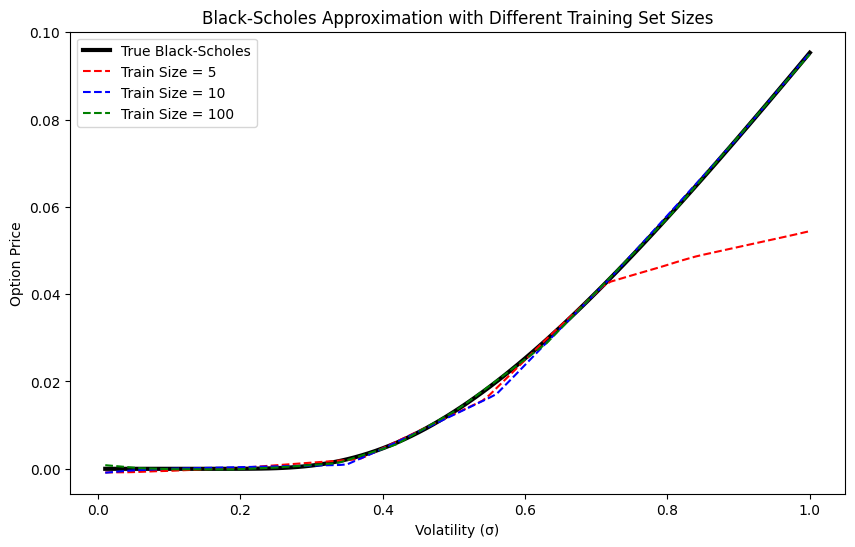

In [ ]:
model_5, X_train_5, y_train_5 = train_model(num_samples=5)
model_10, X_train_10, y_train_10 = train_model(num_samples=10)
model_100, X_train_100, y_train_100 = train_model(num_samples=100)

# Generate Test Data
sigma_test = np.linspace(0.01, 1, 100).reshape(-1, 1)
sigma_test_tensor = torch.tensor(sigma_test, dtype=torch.float32)
true_prices = black_scholes_formula(sigma_test)

# Predict Prices Using Trained Models
with torch.no_grad():
    pred_5 = model_5(sigma_test_tensor).numpy()
    pred_10 = model_10(sigma_test_tensor).numpy()
    pred_100 = model_100(sigma_test_tensor).numpy()

# Plot Results
plt.figure(figsize=(10, 6))
plt.plot(sigma_test, true_prices, label="True Black-Scholes", linewidth=3, color="black")
plt.plot(sigma_test, pred_5, label="Train Size = 5", linestyle="dashed", color="red")
plt.plot(sigma_test, pred_10, label="Train Size = 10", linestyle="dashed", color="blue")
plt.plot(sigma_test, pred_100, label="Train Size = 100", linestyle="dashed", color="green")

plt.xlabel("Volatility (σ)")
plt.ylabel("Option Price")
plt.title("Black-Scholes Approximation with Different Training Set Sizes")
plt.legend()
plt.show()

**Test 2**: Fix the train set and vary the **number of hidden layers**


Epoch 0: Loss = 0.190154
Epoch 50: Loss = 0.000342
Epoch 100: Loss = 0.000016
Epoch 150: Loss = 0.000011
Epoch 200: Loss = 0.000007
Epoch 250: Loss = 0.000005
Epoch 300: Loss = 0.000003
Epoch 350: Loss = 0.000003
Epoch 400: Loss = 0.000002
Epoch 450: Loss = 0.000002
Epoch 0: Loss = 0.026701
Epoch 50: Loss = 0.000013
Epoch 100: Loss = 0.000002
Epoch 150: Loss = 0.000001
Epoch 200: Loss = 0.000000
Epoch 250: Loss = 0.000000
Epoch 300: Loss = 0.000000
Epoch 350: Loss = 0.000000
Epoch 400: Loss = 0.000000
Epoch 450: Loss = 0.000000
Epoch 0: Loss = 0.017813
Epoch 50: Loss = 0.000003
Epoch 100: Loss = 0.000000
Epoch 150: Loss = 0.000000
Epoch 200: Loss = 0.000000
Epoch 250: Loss = 0.000000
Epoch 300: Loss = 0.000000
Epoch 350: Loss = 0.000000
Epoch 400: Loss = 0.000000
Epoch 450: Loss = 0.000000


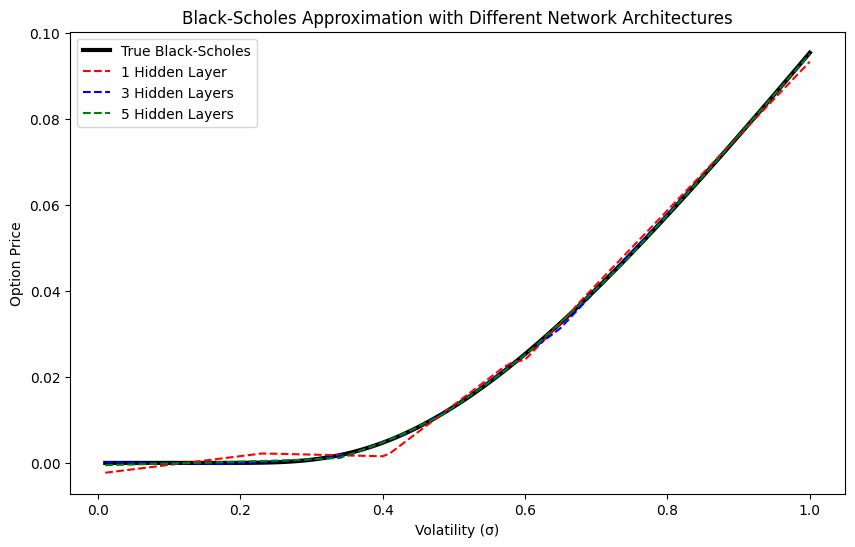

In [ ]:
model_1, _, _ = train_model(num_samples=100, num_layers=1)
model_3, _, _ = train_model(num_samples=100, num_layers=3)
model_5, _, _ = train_model(num_samples=100, num_layers=5)

# Generate Test Data
sigma_test = np.linspace(0.01, 1, 100).reshape(-1, 1)
sigma_test_tensor = torch.tensor(sigma_test, dtype=torch.float32)
true_prices = black_scholes_formula(sigma_test)

# Predict Prices Using Trained Models
with torch.no_grad():
    pred_1 = model_1(sigma_test_tensor).numpy()
    pred_3 = model_3(sigma_test_tensor).numpy()
    pred_5 = model_5(sigma_test_tensor).numpy()

# Plot Results
plt.figure(figsize=(10, 6))
plt.plot(sigma_test, true_prices, label="True Black-Scholes", linewidth=3, color="black")
plt.plot(sigma_test, pred_1, label="1 Hidden Layer", linestyle="dashed", color="red")
plt.plot(sigma_test, pred_3, label="3 Hidden Layers", linestyle="dashed", color="blue")
plt.plot(sigma_test, pred_5, label="5 Hidden Layers", linestyle="dashed", color="green")

plt.xlabel("Volatility (σ)")
plt.ylabel("Option Price")
plt.title("Black-Scholes Approximation with Different Network Architectures")
plt.legend()
plt.show()